## Introduction

### 机器学习的定义与分类

机器学习研究如何从数据中学习其隐藏的模式并预测未知数据的特征。

根据预测变量是否已知，机器学习通常分为两类：**监督学习**和**无监督学习**。
 
- 监督学习

模型通过特征和类别标签作为构建模型的输入。如果目标变量（要预测的变量）是类别信息（例如正/负），该问题称为分类问题。如果目标变量是连续的（例如身高）则为回归问题。

- 无监督学习

目标变量是未指定的。模型的目的是确定内部数据的结构（cluster）。在模型拟合之后，我们可以将新来的样本分给cluster或生成与原始数据具有相似分布的样本。无监督学习也可以用于监督学习之前的数据预处理步骤。

### 本章教程使用指南
读者将会发现，机器学习的核心模型已经被**scikit-learn**等工具包非常好的模块化了，调用起来非常简单，仅需要几行代码，但是一个完整的、有效的机器学习工程项目却包括很多步骤，可以包括**数据导入，数据可视化理解，前处理，特征选择，模型训练，参数调整，模型预测，模型评估，后处理**等多个步骤，一个在真实世界中有效的模型可能需要工作者对数据的深入理解，以选择各个步骤合适的方法。

通过本章教程，读者可以对机器学习的基本概念方法和具体流程有所了解，而且可以通过实践更好地掌握python相关工具包的使用，为后续的应用做好准备。

读者初次阅读和进行代码实践时，可以将重点放在对方法和概念的理解上，对于一些稍微复杂的代码，不需要理解代码里的每个细节。

## 导入需要的Python工具包

这里我们会导入一些后续操作需要的python工具包，它们的相关文档如下，请有兴趣的读者重点学习和了解[scikit-learn](http://scikit-learn.org/)工具包。

* [numpy](https://docs.scipy.org/doc/numpy/): arrays
* [pandas](https://pandas.pydata.org/): data IO, DataFrame
* [imbalanced-learn](https://imbalanced-learn.readthedocs.io/en/stable): deal with class imbalance
* [scikit-learn](http://scikit-learn.org/): machine learning
* [statsmodels](https://www.statsmodels.org/): statistical functions
* [matplotlib](https://matplotlib.org/): plotting
* [seaborn](https://matplotlib.org/): high-level plotting based on *matplotlib*
* [jupyter](https://jupyter.org/): Python notebook
* [mlxtend](https://rasbt.github.io/mlxtend): Extension of scikit-learn
* [graphviz](https://graphviz.readthedocs.io/en/stable/): Python binding for Graphviz graph drawing software
* [wand](http://docs.wand-py.org/en/0.4.4/): ImageMagick (image processing tool) binding for Python

In [1]:
%pylab inline
from collections import defaultdict
# For data importing
import pandas as pd
# For machine learning
from sklearn.datasets import make_classification, make_regression, make_circles, make_moons, make_gaussian_quantiles
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.svm import SVC, LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score, precision_score, \
    roc_curve, precision_recall_curve, average_precision_score, matthews_corrcoef, confusion_matrix
from statsmodels.robust.scale import mad
from scipy.stats import pearsonr
# For plotting
import seaborn as sns
sns.set()
sns.set_style('whitegrid')
from matplotlib.colors import to_hex

random_state = np.random.RandomState(1289237)  #我们在本教程中固定numpy的随机种子，以使结果可重现

Populating the interactive namespace from numpy and matplotlib


## 产生数据集

在处理真实世界的数据集之前，我们先产生一些模拟的数据集来学习机器学习的基本概念。
*scikit-learn* 提供了很多方法([sklearn.datasets](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets)) 来方便地产生数据集。

### 分类问题数据集
我们可以产生一个标签为离散值的用于分类问题的数据集

[sklearn.datasets.make_classification](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html#sklearn.datasets.make_classification) 可以从一个混合高斯分布中产生样本，并且可以控制样本数量，类别数量和特征数量。

我们会产生一个数据集，共有1000个样本，两种类别，四种特征。

#### 产生数据

In [2]:
X, y = make_classification(n_samples=1000, n_classes=2, n_features=4,
                           n_informative=2, n_redundant=0, n_clusters_per_class=1,
                           class_sep=0.9, random_state=random_state)
X.shape, y.shape #查看特征和标签的shape

((1000, 4), (1000,))

#### 用matplotlib可视化样本数据的分布

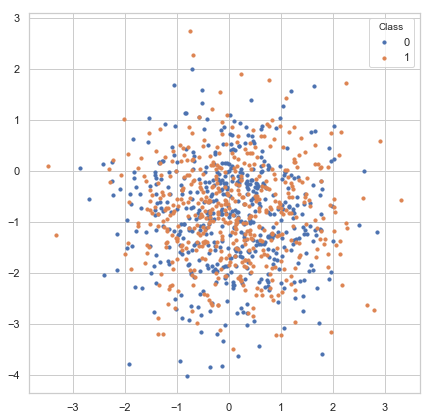

In [3]:
fig, ax = plt.subplots(figsize=(7, 7))
for label in np.unique(y):
    ax.scatter(X[y == label, 0], X[y == label, 1], s=10, label=str(label))
ax.legend(title='Class')

## Data scaling

对于大多数机器学习算法，建议将feature scale到一个比较小的范围，以减少极端值的影响。

feature的规模过大或者过小都会增加数值不稳定的风险并且还使损失函数更加难以优化。
- 基于线性模型权重的特征选择方法会假定输入的feature在同样的规模上。
- 基于梯度下降算法的模型（比如神经网络）的表现和收敛速度会被没有合理scale的数据显著影响。
- 决策树和随机森林类算法对数据规模不太敏感，因为它们使用rule-based标准。

常见的数据缩放方法包括：
>
- standard/z-score scaling

Standard/z-score scaling first shift features to their centers(mean) and then divide by their standard deviation.
This method is suitable for most continous features of approximately Gaussian distribution.

$$ \text{zscore}(x_{ij}^{'}) = \frac{x_{ij} - \mu _{ij}}{\sigma _i} $$

- min-max scaling

Min-max scaling method scales data into range \[0, 1\].
This method is suitable for data concentrated within a range and preserves zero values for sparse data.
Min-max scaling is also sensitive to outliers in the data. Try removing outliers or clip data into
a range before scaling.

$$ \text{min_max}(x_{ij}^{'}) = \frac{x_{ij} - \text{min}_k \mathbf{x}_{ik}}
{\text{max}_k x_{ik} - \text{min}_k x_{ik}} $$


- abs-max scaling.

Max-abs scaling method is similar to min-max scaling, but scales data into range \[-1, 1\].
It does not shift/center the data and thus preserves signs (positive/negative) of features.
Like min-max, max-abs is sensitive to outliers.

$$ \text{max_abs}(x_{ij}^{'}) = \frac{x_{ij}}{\text{max}_k \vert x_{ik} \vert} $$

- robust scaling

Robust scaling method use robust statistics (median, interquartile range) instead of mean and standard deviation.
Median and IQR are less sensitive to outliers.
For features with large numbers of outliers or largely deviates from normal distribution, 
robust scaling is recommended.

$$ \text{robust_scale}(x_{ij}^{'}) = \frac{x_{ij} - \text{median}_k x_{ik}}
{Q_{0.75}(\mathbf{x}_i) - Q_{0.25}(\mathbf{x}_i)} $$

### 使用standard/z-score scaling 对数据做scaling
使用方法如下：

In [4]:
X = StandardScaler().fit_transform(X)

Text(0.5,1,u'scaled data distribution by standard scaling')

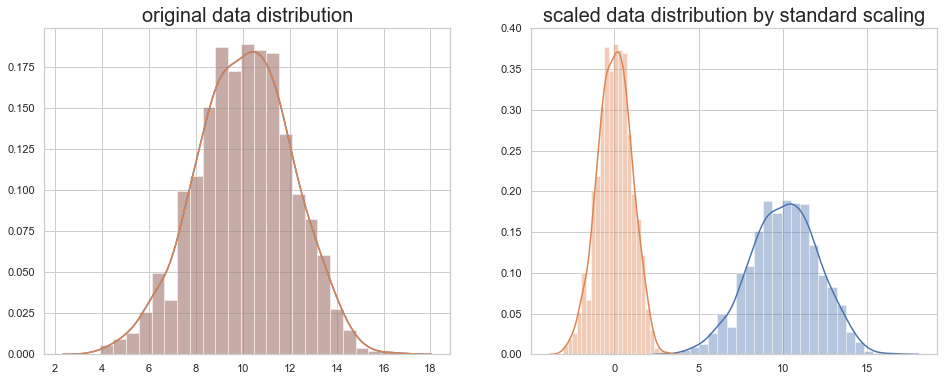

In [5]:
#产生模拟数据，1000个数据点，均值为10，标准差为2
x = random_state.normal(10, 2, size=1000)
fig, ax = plt.subplots(1,2,figsize=(16, 6))
sns.distplot(x, ax=ax[0])
sns.distplot(x, ax=ax[1])
sns.distplot(np.ravel(x), ax=ax[0])
sns.distplot(np.ravel(StandardScaler().fit_transform(x.reshape((-1, 1)))), ax=ax[1])
ax[0].set_title('original data distribution',fontsize=20)
ax[1].set_title('scaled data distribution by standard scaling',fontsize=20)

## 划分数据得到训练集和测试集（training set & test set）

到这里，我们已经对数据进行了一些分析，并且做了一些基本的预处理，接下来我们需要对数据进行划分，得到训练集和测试集，通过训练集中的数据训练模型，再通过测试集的数据评估模型的表现。

因为模型总是会在某种程度上过拟合训练数据，因此在训练数据上评估模型是有偏的，模型在训练集上的表现总会比测试集上好一些。

因为模型总是可以学到数据中隐藏的模式和分布，如果样本间彼此的差异比较大，过拟合问题就会得到一定程度的减轻。而如果数据的量比较大，模型在训练集和测试集上的表现差异就会减小。


这里我们使用[train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
方法来随机的将80%的样本设置为训练样本， 将其余20%设置为测试样本。


另一个常见的概念是验证集（validation set），通过将训练集再随机划分为训练集和验证集，进行多折交叉验证（[cross validation](https://www.zhihu.com/question/39259296)），可以帮助我们评估不同的模型，调整模型的超参数等，此外交叉验证在数据集较小的时候也被用于直接评估模型的表现，我们在交叉验证部分还会详细讲解。

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
print('number of training samples: {}, test samples: {}'.format(X_train.shape[0], X_test.shape[0]))

number of training samples: 800, test samples: 200


## 模型训练

在模型训练的过程中，模型内部的参数会调整以最小化[损失函数](http://www.csuldw.com/2016/03/26/2016-03-26-loss-function/)。

### 逻辑斯谛回归

逻辑斯谛回归是一个简单但是非常有效的模型，与它的名字不同，逻辑斯谛回归用于解决分类问题，在二分类问题中被广泛使用。对于二分类问题，我们需要对每一个样本预测它属于哪一类（0或者1）。

逻辑斯谛回归是一个线性分类模型，它会对输入的feature进行线性组合，然后将线性组合组合得到的值通过一个非线性的sigmoid函数映射为一个概率值(范围为0~1)。

模型训练过程中，模型内部的参数（线性模型的权重）会调整使得模型的损失函数（真实label和预测label的交叉熵）最小。

$$ p(y_i | \mathbf{x}_i) = \frac{1}{1 + \text{exp} \left( \sum_{j=1}^M x_{ij} w_{j} + b \right)} $$

#### 调用逻辑回归模型并且训练模型
使用sklearn封装好的模型进行模型的训练非常简单，以逻辑斯谛回归模型为例，只需要两行即可完成模型的训练。

我们使用默认参数进行训练。

In [7]:
model = LogisticRegression()
_ = model.fit(X_train, y_train)
model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

## 模型评估

### 在测试集上预测样本类别

为了评估模型表现，我们需要对测试集样本进行预测，我们使用*predict*方法来预测样本类别，它会返回一个整数型array来表示不同的样本类别。

In [8]:
y_pred = model.predict(X_test)
y_pred

array([1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 0])

### Confusion matrix

最常用的评估分类模型表现的方法是构建一个[confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).

Confusion matrix会总结模型正确和错误分类的样本数量，并将预测的样本分成如下四类： 

|  | Predicted | Negative | Positive ||
| :--- | :--- | :--- | :--- |:---|
| **True** |  |  |  ||
| **Negative** |  | True Negative \(TN\) | False Negative \(FN\) | $\textbf{NPV} =\frac{TN}{TN+FN}$ |
| **Positive** |  | False Positive \(FP\) | True Positive \(TP\) |$\textbf{PPV} =\frac{TP}{TP+FP}$|
| | | $\textbf{Specificity} = \frac{TN}{TN+FP}$ |$\textbf{Sensiticity} = \frac{TP}{TP+FN}$| |

#### 构建预测结果的Confusion matrix
使用scikit-learn的confusion_matrix方法即可得到模型预测结果的confusion matrix

In [9]:
pd.DataFrame(confusion_matrix(y_test, y_pred), 
             columns=pd.Series(['Negative', 'Positive'], name='Predicted'),
             index=pd.Series(['Negative', 'Positive'], name='True'))

Predicted,Negative,Positive
True,,
Negative,85,13
Positive,10,92


### 分类问题的评估指标



通过confusion matrix中的四个数据(TP, TN, FP, FN)可以得到一系列相应的评估分类问题的指标：

- **Accuracy (0 ~ 1)** 

summarizes both positive and negative predictions, but is biased if the classes are imbalanced:
$$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$$

- **Recall/sensitivity (0 ~ 1)**

summarizes how well the model finds out positive samples:
$$\text{Recall/Sensitivity} = \frac{TP}{TP + FN}$$

- **Precision/positive predictive value (0 ~ 1)** 

summarizes how well the model finds out negative samples:
$$\text{Precision/Positive Predictive Value} = \frac{TP}{TP + FP}$$

- **F1 score (0 ~ 1)** 

balances between positive predictive value (PPV) and true positive rate (TPR) and is more suitable for
imbalanced dataset:
$$\text{F1 score} = 2 \frac{PPV \cdot TPR}{PPV + TPR}$$

- **Matthews correlation coefficient (MCC) (-1 ~ 1)** 

another metric that balances between recall and precision:
$$\text{MCC} = \frac{TP \times TN - FP \times FN}
{(TP + FN)(TP + FP)(TN + FP)(TN + FN)}$$

In [10]:
scorers = {'accuracy': accuracy_score,
           'recall': recall_score,
           'precision': precision_score,
           'f1': f1_score,
           'mcc': matthews_corrcoef
}
for metric in scorers.keys():
    print('{} = {}'.format(metric, scorers[metric](y_test, y_pred)))

f1 = 0.888888888889
recall = 0.901960784314
mcc = 0.770117094931
precision = 0.87619047619
accuracy = 0.885


### ROC曲线和Precision-Recall曲线

有时，一个固定的cutoff不足以评估模型性能。
Receiver Operating Characterisic（ROC）曲线和Precision-Recall曲线可以通过不同的cutoff评估模型的表现。 ROC曲线和Precision-Recall对于类别不平衡问题也有比较好的评估。与ROC曲线相比，recision-Recall曲线更适合类别极不平衡的数据集。

ROC曲线下面积（AUROC）或average precision (AP)是一个单值，它总结了不同截止值下的模型平均表现，常常用于报告模型的分类表现。

#### 绘制ROC曲线和Precision-Recall曲线
我们使用sklearn自带的*roc_curve*和*precision_recall_curve*方法来计算绘图需要的指标，这两个方法需要的输入为测试集每个样本的真实标签和模型预测的每个样本的概率。

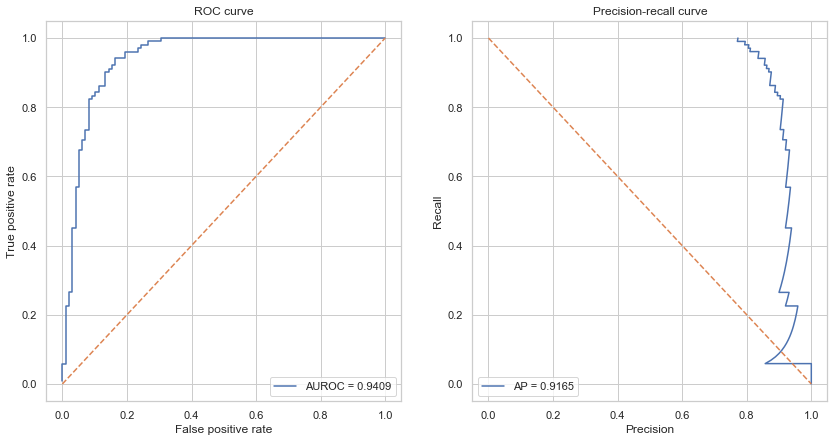

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
# ROC curve
y_score = model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1])
ax = axes[0]
ax.plot(fpr, tpr, label='AUROC = {:.4f}'.format(roc_auc_score(y_test, y_score[:, 1])))
ax.plot([0, 1], [0, 1], linestyle='dashed')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.set_title('ROC curve')
ax.legend()
# predision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score[:, 1])
ax = axes[1]
ax.plot(precision, recall, label='AP = {:.4f}'.format(average_precision_score(y_test, y_score[:, 1])))
ax.plot([0, 1], [1, 0], linestyle='dashed')
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')
ax.set_title('Precision-recall curve')
ax.legend()

可以看到AUROC和AP都接近于1，可以认为模型的分类效果很好。

## 交叉验证

交叉验证可以被用于在训练集中再随机划分出一部分验证集用于挑选模型的参数，也可以用于直接评估模型的表现。

对于非常大的数据集，将数据集单独拆分为训练集和测试集就足够来评估模型性能。但是，对于小型数据集，测试样本仅代表一小部分未来预测中可能的样本，即对于小数据集，划分出的测试集可能因为样本数过少而不具有代表性。


### K折（k-folds）交叉验证

交叉验证是小型数据集模型评估的常用技术。
在**k折交叉验证**中，数据集被均匀地划分为*k*个部分（folds）。
在每轮验证中，模型在一个fold上进行测试，并在剩余的*（k-1）/ k *部分上进行训练。 

K折交叉验证确保训练样本和测试样本之间没有重叠，K轮结束后，每个样本会被设置为测试样品一次。最后，模型平均表现是在* k*轮次中计算的。



*scikit-learn*提供很多功能来[划分数据集]
(http://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection).

这里我们使用[KFold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html)
来将数据集划分为10折，5和10是交叉验证中经常使用的折数。如果样本数量和计算资源允许，一般设置为10折。

下面的代码展示*KFold*是如何划分数据集的，图片中每一行为一个轮次，每一行中黑色的box为该轮次的测试集

Text(0.5,0,u'Sample')

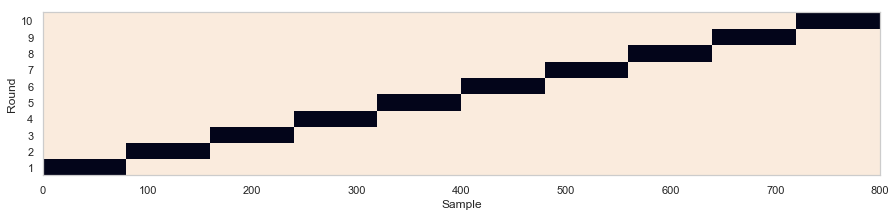

In [19]:
n_splits = 10

kfold = KFold(n_splits=n_splits, random_state=random_state)
is_train = np.zeros((n_splits, X_train.shape[0]), dtype=np.bool)
for i, (train_index, test_index) in enumerate(kfold.split(X_train, y_train)):
    is_train[i, train_index] = 1

fig, ax = plt.subplots(figsize=(15, 3))
ax.pcolormesh(is_train)
ax.set_yticks(np.arange(n_splits) + 0.5)
ax.set_yticklabels(np.arange(n_splits) + 1)
ax.set_ylabel('Round')
ax.set_xlabel('Sample')

接下来我们在训练集上训练模型，并且对整个数据集进行预测，这样我们可以分析模型在10折交叉验证中每一轮时在训练集和测试集分别的表现。

In [22]:
predictions = np.zeros((n_splits, X_train.shape[0]), dtype=np.int32)
predicted_scores = np.zeros((n_splits, X_train.shape[0]))

for i in range(n_splits):
    model.fit(X_train[is_train[i]], y_train[is_train[i]])
    predictions[i] = model.predict(X_train)
    predicted_scores[i] = model.predict_proba(X_train)[:, 1]

### Collect evaluation metrics

我们统计了模型10折交叉验证的指标

In [23]:
cv_metrics = pd.DataFrame(np.zeros((n_splits*2, len(scorers) + 2)),
                          columns=list(scorers.keys()) + ['roc_auc', 'average_precision'])
cv_metrics.loc[:, 'dataset'] = np.empty(n_splits*2, dtype='U')
for i in range(n_splits):
    for metric in scorers.keys():
        cv_metrics.loc[i*2 + 0, metric] = scorers[metric](y_train[is_train[i]], predictions[i, is_train[i]])
        cv_metrics.loc[i*2 + 1, metric] = scorers[metric](y_train[~is_train[i]], predictions[i, ~is_train[i]])
    cv_metrics.loc[i*2 + 0, 'roc_auc'] = roc_auc_score(y_train[is_train[i]], predicted_scores[i, is_train[i]])
    cv_metrics.loc[i*2 + 1, 'roc_auc'] = roc_auc_score(y_train[~is_train[i]], predicted_scores[i, ~is_train[i]])
    cv_metrics.loc[i*2 + 0, 'average_precision'] = average_precision_score(y_train[is_train[i]], 
                                                                           predicted_scores[i, is_train[i]])
    cv_metrics.loc[i*2 + 1, 'average_precision'] = average_precision_score(y_train[~is_train[i]], 
                                                                           predicted_scores[i, ~is_train[i]])
    cv_metrics.loc[i*2 + 0, 'dataset'] = 'train'
    cv_metrics.loc[i*2 + 1, 'dataset'] = 'valid'

cv_metrics

,f1,recall,mcc,precision,accuracy,roc_auc,average_precision,dataset
0,0.878179,0.903581,0.748357,0.854167,0.873611,0.941207,0.923974,train
1,0.845070,0.833333,0.721750,0.857143,0.862500,0.933712,0.935387,valid
2,0.882834,0.902507,0.761891,0.864000,0.880556,0.943726,0.924183,train
3,0.813953,0.875000,0.606866,0.760870,0.800000,0.913125,0.905351,valid
4,0.876011,0.900277,0.745555,0.853018,0.872222,0.938294,0.919266,train
5,0.897436,0.921053,0.801002,0.875000,0.900000,0.959900,0.950735,valid
6,0.867769,0.884831,0.733970,0.851351,0.866667,0.939244,0.920460,train
7,0.921348,0.953488,0.825387,0.891304,0.912500,0.948460,0.930326,valid
8,0.875000,0.900000,0.751351,0.851351,0.875000,0.940865,0.919294,train
9,0.907216,0.897959,0.764660,0.916667,0.887500,0.940092,0.953203,valid


### 总结评估指标

我们评估多轮交叉验证的平均指标如下：

In [24]:
cv_metrics_mean = cv_metrics.groupby('dataset').mean()
cv_metrics_mean

,f1,recall,mcc,precision,accuracy,roc_auc,average_precision
dataset,,,,,,,
train,0.877278,0.899152,0.750097,0.856463,0.874583,0.940857,0.922722
valid,0.870846,0.896885,0.742149,0.850640,0.870000,0.940218,0.924818


接下来我们绘制散点图来展示模型七个指标：*accuracy,recall,precision,f1,mcc,roc_auc,average_precision*分别在十折交叉验证中的值：

Text(0.5,1,u'Model performance using 10-fold cross-validation')

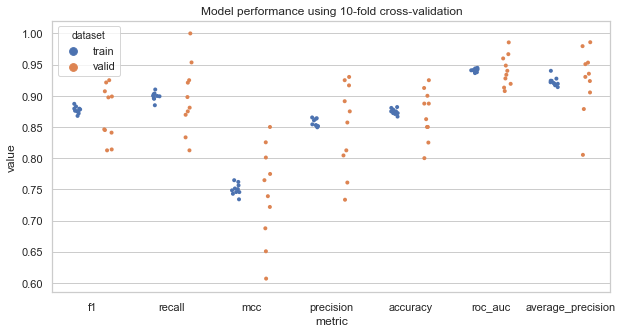

In [25]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_data = pd.melt(cv_metrics, id_vars=['dataset'], var_name='metric', value_name='value')
sns.stripplot(x='metric', y='value', hue='dataset', 
              dodge=True, jitter=True, data=plot_data, size=4, ax=ax)
#sns.pointplot(x='metric', y='value', hue='dataset', data=plot_data, markers="d", 
#              join=False, ci=None, ax=ax, dodge=True, palette='dark')
ax.set_title('Model performance using 10-fold cross-validation')

### ROC 和 PR 曲线

对每一轮交叉验证结果，我们都可以绘制一条ROC/PR曲线，当我们把十条曲线绘制在一起时，更好的方法是绘制十轮结果的均值曲线，以及用阴影区域表示十轮结果的置信区间。
> tips: Anaconda并没有集成seaborn的最新版本，如果运行代码时报错，请使用pip更新seaborn：`pip install seaborn==0.9.0`

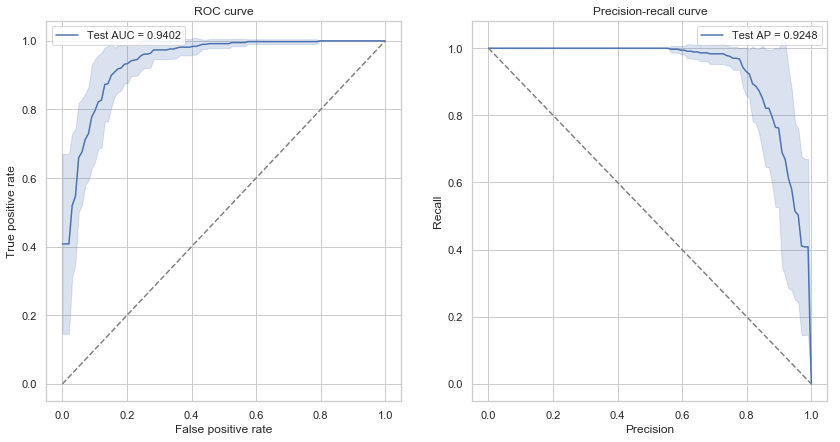

In [29]:
from scipy import interp

fig, axes = plt.subplots(1, 2, figsize=(14, 7))
# ROC curve
ax = axes[0]
all_fprs = np.linspace(0, 1, 100)
roc_curves = np.zeros((n_splits, len(all_fprs), 2))
for i in range(n_splits):
    fpr, tpr, thresholds = roc_curve(y_train[~is_train[i]], predicted_scores[i, ~is_train[i]])
    roc_curves[i, :, 0] = all_fprs
    roc_curves[i, :, 1] = interp(all_fprs, fpr, tpr)
roc_curves = pd.DataFrame(roc_curves.reshape((-1, 2)), columns=['fpr', 'tpr'])
sns.lineplot(x='fpr', y='tpr', data=roc_curves, ci='sd', ax=ax,
             label='Test AUC = {:.4f}'.format(cv_metrics_mean.loc['valid', 'roc_auc']))
#ax.plot(fpr, tpr, label='ROAUC = {:.4f}'.format(roc_auc_score(y_test, y_score[:, 1])))
#ax.plot([0, 1], [0, 1], linestyle='dashed')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.plot([0, 1], [0, 1], linestyle='dashed', color='gray')
ax.set_title('ROC curve')
ax.legend()

# predision-recall curve
ax = axes[1]
all_precs = np.linspace(0, 1, 100)
pr_curves = np.zeros((n_splits, len(all_precs), 2))
for i in range(n_splits):
    fpr, tpr, thresholds = precision_recall_curve(y_train[~is_train[i]], predicted_scores[i, ~is_train[i]])
    pr_curves[i, :, 0] = all_precs
    pr_curves[i, :, 1] = interp(all_precs, fpr, tpr)
pr_curves = pd.DataFrame(pr_curves.reshape((-1, 2)), columns=['precision', 'recall'])
sns.lineplot(x='precision', y='recall', data=pr_curves, ci='sd', ax=ax,
             label='Test AP = {:.4f}'.format(cv_metrics_mean.loc['valid', 'average_precision']))

ax.set_xlabel('Precision')
ax.set_ylabel('Recall')
ax.plot([0, 1], [1, 0], linestyle='dashed', color='gray')
ax.set_title('Precision-recall curve')
ax.legend()

## Advanced
- [**Machine Learning**](https://lulab.gitbook.io/training/part-iii.-advanced-bioinfo-analyses/1.machine-learning-basics)
- [**Feature Selection**](https://lulab.gitbook.io/training/part-iii.-advanced-bioinfo-analyses/2.feature-selection)

## 课外阅读

### 书籍

1. Trevor Hastie, Robert Tibshirani, Jerome Friedman. (2009). The Elements of Statistical Learning. 
2. Christopher Bishop. (2006). Pattern Recognition and Machine Learning.
3. Kevin P. Murphy. (2012). Machine Learning A Probabilisitic Perspective.
4. Sergios Theodoridis. (2009). Pattern Recognition.

### 类别不平衡问题

1. He, H., and Garcia, E.A. (2009). Learning from Imbalanced Data. IEEE Transactions on Knowledge and Data Engineering 21, 1263–1284.
2. Batista, G.E.A.P.A., Prati, R.C., and Monard, M.C. (2004). A Study of the Behavior of Several Methods for Balancing Machine Learning Training Data. SIGKDD Explor. Newsl. 6, 20–29.
3. Chawla, N.V., Bowyer, K.W., Hall, L.O., and Kegelmeyer, W.P. (2002). SMOTE: Synthetic Minority Over-sampling Technique. J. Artif. Int. Res. 16, 321–357.

### Machine learning in R

The *caret* package (a tutorial in GitBook): [http://topepo.github.io/caret](http://topepo.github.io/caret)

## Homework

1. 理解并且运行教程中的代码，你也可以重新生成数据集，或者使用真实的数据集。

2. 使用教程中已有的代码，用不同的分类器 (SVC, random forest, logistic regression) 训练并进行预测，使用十折交叉验证比较模型的表现。汇报accuracy, recall,precision,f1,mcc,roc_auc等指标。绘制ROC曲线。

3. （选做）在做交叉验证时使用不同的K值，比较模型的表现。

4. （选做）修改样本的类别比例，在类别不均衡数据上比较模型的表现。